In [1]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/

In [2]:
!kaggle datasets download -d salader/dogs-vs-cats

Dataset URL: https://www.kaggle.com/datasets/salader/dogs-vs-cats
License(s): unknown
 98% 1.05G/1.06G [00:04<00:00, 223MB/s]
100% 1.06G/1.06G [00:04<00:00, 241MB/s]


In [3]:
import zipfile
zip_ref = zipfile.ZipFile("/content/dogs-vs-cats.zip", "r")
zip_ref.extractall("/content")
zip_ref.close()

In [17]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf
from tensorflow import keras
from keras import Sequential
from keras.layers import Dense, Conv2D, Flatten, MaxPooling2D, BatchNormalization
from keras.layers import Dropout
from keras.callbacks import EarlyStopping
from tensorflow.keras.models import load_model

In [5]:
# generators

# Keras offers us a function to create Generator for our data to create batches
# of dataset so that It won't put load on GPU.


# For training data file
train_dataset = keras.utils.image_dataset_from_directory(
    directory = "/content/train",
    labels = "inferred",
    label_mode = "int",
    batch_size = 32,
    image_size = (256,256)
)


# For Validation(test) data file
validation_dataset = keras.utils.image_dataset_from_directory(
    directory = "/content/test",
    labels = "inferred",
    label_mode = "int",
    batch_size = 32,
    image_size = (256,256)
)

Found 20000 files belonging to 2 classes.
Found 5000 files belonging to 2 classes.


In [6]:
# Normalize

# Generally all of our Image data has pixel values from 0-255.
# and we can reduce it in range of 0-1 for better results.
# This is called Normalization of Image.

# Creating a function for it
def process(image, label):
  image = tf.cast(image/255, tf.float32)
  return image, label

train_dataset = train_dataset.map(process)
validation_dataset = validation_dataset.map(process)

In [26]:
# Creating 1st CNN Model (Architecture)  >>(Convolutional Neural Network)<<

# Sequential acts as a Base layer on which we can add multiple layers to create
# a Model
model = Sequential()

# 1st Layer of 32 Filters
model.add(Conv2D(32, kernel_size = (3,3), padding = "valid", activation = "relu",
                  input_shape = (256, 256, 3)))
model.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = "valid"))

# 2nd layer of 64 filters
model.add(Conv2D(64, kernel_size = (3,3), padding = "valid", activation = "relu",))
model.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = "valid"))

# 3rd layer of 128 filters
model.add(Conv2D(128, kernel_size = (3,3), padding = "valid", activation = "relu",))
model.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = "valid"))

# 4th layer of 256 filters
model.add(Conv2D(256, kernel_size = (3,3), padding = "valid", activation = "relu",))
model.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = "valid"))

# 5th Flatten layer (nD ---> 1D)
model.add(Flatten())

# Dense Layers to Sum up all and to give 1 unit after passing through Model
model.add(Dense(256, activation = "relu"))
model.add(Dense(128, activation = "relu"))
model.add(Dense(64, activation = "relu"))
model.add(Dense(1, activation = "sigmoid"))

In [27]:
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_3 (Conv2D)                    │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_3 (MaxPooling2D)       │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_4 (MaxPooling2D)       │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_5 (Conv2D)                    │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_5 (MaxPooling2D)       │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_6 (Conv2D)                    │ (None, 28, 28, 256)         │         295,168 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 14, 14, 256)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_1 (Flatten)                  │ (None, 50176)               │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 256)                 │      12,845,312 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_4 (Dense)                      │ (None, 128)                 │          32,896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 13,274,945 (50.64 MB)

 Trainable params: 13,274,945 (50.64 MB)

 Non-trainable params: 0 (0.00 B)

In [29]:
model.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

# Early Stopping to stop the training if loss is not improving
early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights = True
    )


In [30]:
history = model.fit(train_dataset, epochs = 15, validation_data = validation_dataset,
                    callbacks = [early_stopping])

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 65s 87ms/step - accuracy: 0.5991 - loss: 0.6571 - val_accuracy: 0.7368 - val_loss: 0.5409
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 55s 88ms/step - accuracy: 0.7571 - loss: 0.5039 - val_accuracy: 0.8172 - val_loss: 0.4214
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 78s 82ms/step - accuracy: 0.8247 - loss: 0.3873 - val_accuracy: 0.8436 - val_loss: 0.3660
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 86ms/step - accuracy: 0.8715 - loss: 0.2996 - val_accuracy: 0.8442 - val_loss: 0.3774
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 86ms/step - accuracy: 0.9154 - loss: 0.2097 - val_accuracy: 0.8506 - val_loss: 0.4299
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 82ms/step - accuracy: 0.9499 - loss: 0.1291 - val_accuracy: 0.8414 - val_loss: 0.5327
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 82s 82ms/step - accuracy: 0.9679 - loss: 0.0852 - val_accuracy: 0.8338 - val_loss: 0.7278
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 80s 80ms/step - accuracy: 0.9784 - loss: 0.0618 - 

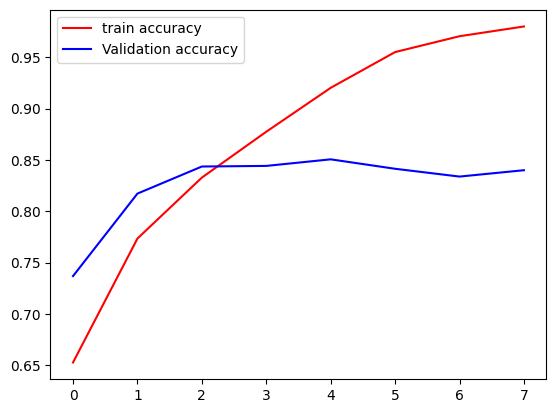

In [31]:
import matplotlib.pyplot as plt

plt.plot(history.history["accuracy"], color = "red", label = "train accuracy")
plt.plot(history.history["val_accuracy"], color = "blue", label = "Validation accuracy")
plt.legend()
plt.show()

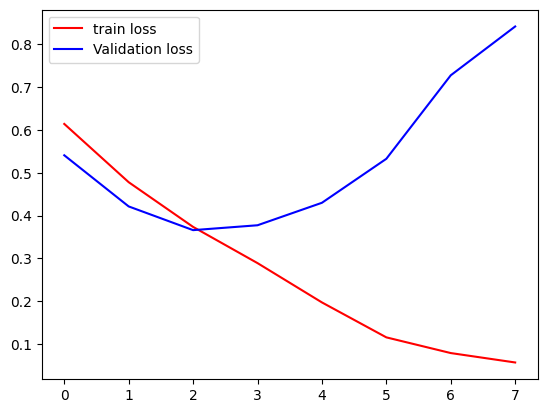

In [32]:
plt.plot(history.history["loss"], color = "red", label = "train loss")
plt.plot(history.history["val_loss"], color = "blue", label = "Validation loss")
plt.legend()
plt.show()

In [39]:
model.save("/content/model_1.h5")
print("Model saved successfully !")

Model saved successfully !


# Now using ---> **Dropout** and ---> **BatchNoramalization** for reducing the **Overfitting** Problem and improve Models Performance

In [40]:
# Creating 2nd CNN Model (Architecture)

# Sequential acts as a Base layer on which we can add multiple layers to create a Model
model_2 = Sequential()

# 1st Layer of 32 Filters
model_2.add(Conv2D(32, kernel_size = (3,3), padding = "valid", activation = "relu",
                  input_shape = (256, 256, 3)))
model_2.add(BatchNormalization())            # Extra Batchnormalization
model_2.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = "valid"))

# 2nd layer of 64 filters
model_2.add(Conv2D(64, kernel_size = (3,3), padding = "valid", activation = "relu",))
model_2.add(BatchNormalization())            # Extra Batchnormalization
model_2.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = "valid"))

# 3rd layer of 128 filters
model_2.add(Conv2D(128, kernel_size = (3,3), padding = "valid", activation = "relu",))
model_2.add(BatchNormalization())           # Extra Batchnormalization
model_2.add(MaxPooling2D(pool_size = (2,2), strides = 2, padding = "valid"))


# 5th Flatten layer (nD ---> 1D)
model_2.add(Flatten())

# Dense Layers to Sum up all and to give 1 unit after passing through Model

# Added Extra Drop-Out layers

model_2.add(Dense(128, activation = "relu"))
model_2.add(Dropout(0.2))
model_2.add(Dense(64, activation = "relu"))
model_2.add(Dropout(0.2))
model_2.add(Dense(1, activation = "sigmoid"))

In [41]:
model_2.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_10 (Conv2D)                   │ (None, 254, 254, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_6                │ (None, 254, 254, 32)        │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_10 (MaxPooling2D)      │ (None, 127, 127, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_11 (Conv2D)                   │ (None, 125, 125, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_7                │ (None, 125, 125, 64)        │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_11 (MaxPooling2D)      │ (None, 62, 62, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_12 (Conv2D)                   │ (None, 60, 60, 128)         │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_8                │ (None, 60, 60, 128)         │             512 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_12 (MaxPooling2D)      │ (None, 30, 30, 128)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 115200)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 128)                 │      14,745,728 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_4 (Dropout)                  │ (None, 128)                 │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_5 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_12 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 14,848,193 (56.64 MB)

 Trainable params: 14,847,745 (56.64 MB)

 Non-trainable params: 448 (1.75 KB)

In [42]:
model_2.compile(optimizer = "adam", loss = "binary_crossentropy", metrics = ["accuracy"])

In [79]:

# Early Stopping to stop the training if loss is not improving
early_stopping = EarlyStopping(
    monitor = "val_loss",
    patience = 5,
    restore_best_weights = True
    )


In [80]:
# Training the model on training dataset with epochs

New_trained = model_2.fit(train_dataset, epochs = 15, validation_data = validation_dataset,
                          callbacks = [early_stopping])

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 54s 87ms/step - accuracy: 0.9694 - loss: 0.0644 - val_accuracy: 0.8466 - val_loss: 0.4975
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 53s 84ms/step - accuracy: 0.9728 - loss: 0.0573 - val_accuracy: 0.8182 - val_loss: 0.4719
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 83ms/step - accuracy: 0.9761 - loss: 0.0563 - val_accuracy: 0.8298 - val_loss: 0.5363
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 52s 84ms/step - accuracy: 0.9757 - loss: 0.0541 - val_accuracy: 0.8340 - val_loss: 0.5861
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 81ms/step - accuracy: 0.9760 - loss: 0.0533 - val_accuracy: 0.7960 - val_loss: 0.5798
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 51s 82ms/step - accuracy: 0.9744 - loss: 0.0595 - val_accuracy: 0.8428 - val_loss: 0.8702
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 85s 87ms/step - accuracy: 0.9748 - loss: 0.0538 - val_accuracy: 0.8254 - val_loss: 1.1049


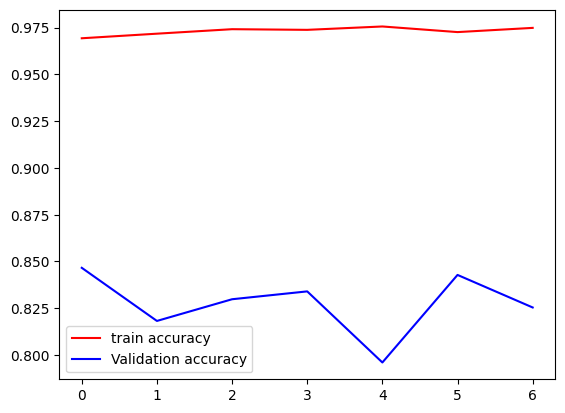

In [81]:
import matplotlib.pyplot as plt

plt.plot(New_trained.history["accuracy"], color = "red", label = "train accuracy")
plt.plot(New_trained.history["val_accuracy"], color = "blue", label = "Validation accuracy")
plt.legend()
plt.show()

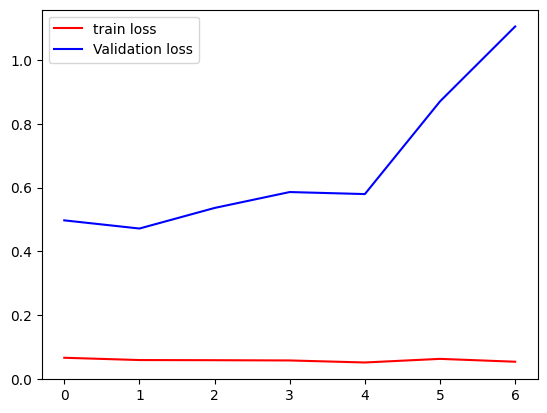

In [82]:
plt.plot(New_trained.history["loss"], color = "red", label = "train loss")
plt.plot(New_trained.history["val_loss"], color = "blue", label = "Validation loss")
plt.legend()
plt.show()

In [49]:
# Example of suppressing by evaluating on dummy data
import numpy as np

dummy_input = np.zeros((1, 256, 256, 3))  # Dummy input matching model input shape
dummy_output = np.zeros((1, 1))  # Dummy output for evaluation
model_2.evaluate(dummy_input, dummy_output, verbose=0)  # Initializes metrics


[0.32164570689201355, 1.0]

# ***SAVING THIS MODEL***


In [83]:
# Saving this model in .H5 file format

model_2.save("/content/model_2_new.h5")
print("Model has been saved successfully!")



Model has been saved successfully!


#***Checking Model on Unseen Data***

> Cat = 0

> Dog = 1



In [14]:
# OpenCV is a Computer Vision Library used for Image Dataset
import cv2

In [ ]:
# Reading images by using cv2.imread() function

test_img_1 = cv2.imread("/content/003.jpeg")
test_img_2 = cv2.imread("/content/001.jpg")

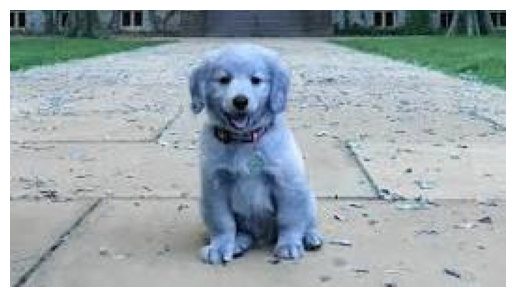

In [ ]:
plt.imshow(test_img_1)
plt.axis("off")
plt.show()

def preprocess_img(img):
  """
  Resizing the Image to cv2.resize(256,256,3)
  Reshaping the Image for Batch 1
  (We have used Generator and that's why we need to provide the Batch for this
   Image hence we used cv.reshape(1,256,256,3))

  """
  img = cv2.resize(img, (256, 256))  # Resizing
  img = img.reshape(1, 256, 256, 3)     # Reshaping
  return img



In [ ]:
test_img_1 = preprocess_img(test_img_1)
test_img_2 = preprocess_img(test_img_2)


In [ ]:
from tensorflow.keras.models import load_model

# Load the trained model
model = load_model("/content/cat_dog_model.h5")

# Evaluate the model on a test dataset
loss, accuracy = model.evaluate(validation_dataset, verbose=1)
print(f"Test Accuracy: {accuracy * 100:.2f}%")


157/157 ━━━━━━━━━━━━━━━━━━━━ 8s 42ms/step - accuracy: 0.8803 - loss: 0.2911
Test Accuracy: 87.96%


In [73]:
def final_prediction(img_path, model_path):
    """
    Predict whether the given image is a Cat or Dog.

    Parameters:
        file_path: Path to the input image of a cat or dog to be classified.
        model: The trained TensorFlow/Keras model for prediction.

    Returns:
        None. Displays the image and prints the prediction.
    """
    # Load the image
    img = cv2.imread(img_path)  # Read the image from the file
    if img is None:
        print("Error: Image not found or cannot be read.")
        return

    # Print the original image shape
    print("Original Image Shape:", img.shape)

    # Preprocess the image
    img = cv2.resize(img, (256, 256))  # Resize to 256x256

    img = img.reshape((1, 256, 256, 3))  # Add batch dimension

    # Print the preprocessed image shape
    print("Preprocessed Image Shape:", img.shape)

    # Make a prediction
    model = load_model(model_path)
    print(f"Model loaded successfully")

    prediction = model.predict(img)
    predicted_class = prediction[0][0]  # Get the class index

    # Display the image
    test_img = cv2.imread(img_path)  # Read the image
    test_img_rgb = cv2.cvtColor(test_img, cv2.COLOR_BGR2RGB)  # Convert BGR to RGB
    plt.imshow(test_img_rgb)  # Display the image
    plt.axis("off")  # Turn off axis
    plt.show()

    # Print the prediction
    if predicted_class <= 0.59:
        print("This is a Cat!")
    elif predicted_class >= 0.60:
        print("This is a Dog!")
    else:
        print("Oops, Sorry! I can't decide this. :)")

Original Image Shape: (360, 540, 3)
Preprocessed Image Shape: (1, 256, 256, 3)


Model loaded successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 309ms/step


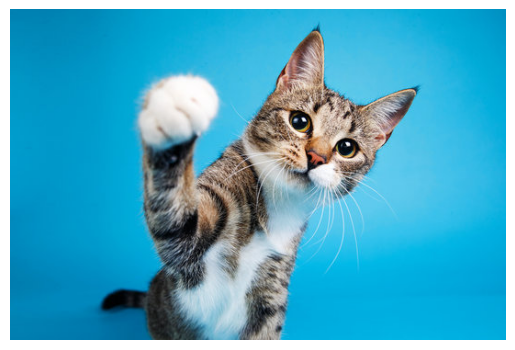

This is a Cat!


In [94]:
final_prediction("/content/001.jpg", "model_2_new.h5")

Original Image Shape: (148, 148, 3)
Preprocessed Image Shape: (1, 256, 256, 3)


Model loaded successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 366ms/step


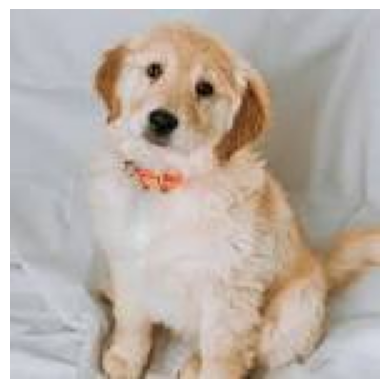

This is a Dog!


In [93]:
final_prediction("/content/002.jpeg", "model_2_new.h5")

Original Image Shape: (148, 265, 3)
Preprocessed Image Shape: (1, 256, 256, 3)


Model loaded successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 478ms/step


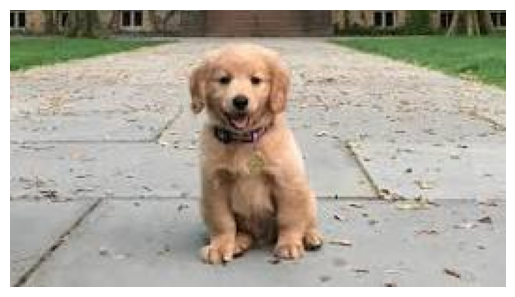

This is a Dog!


In [92]:
final_prediction("/content/003.jpeg", "model_2_new.h5")

Original Image Shape: (275, 183, 3)
Preprocessed Image Shape: (1, 256, 256, 3)


Model loaded successfully
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 301ms/step


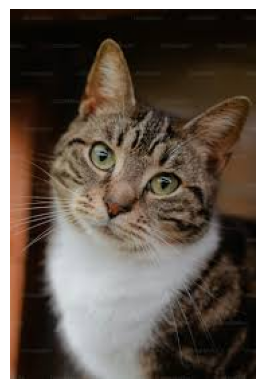

This is a Dog!


In [95]:
final_prediction("/content/006.jpeg", "model_2_new.h5")

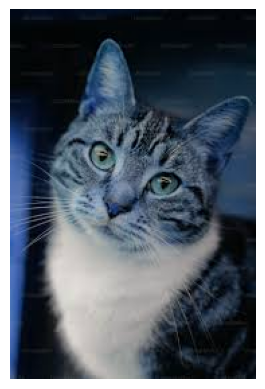

In [96]:
import cv2
import matplotlib.pyplot as plt
import numpy as np
test_img = cv2.imread("/content/006.jpeg")
plt.imshow(test_img)
plt.axis("off")
plt.show()

In [97]:
test_img = cv2.resize(test_img, (256,256))
test_input = test_img.reshape(1,256,256,3)

In [98]:
model = load_model("/content/model_1.h5")
prediction = model.predict(test_input)
print(prediction)
predicted_value = prediction[0][0]
print(predicted_value)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 270ms/step
[[0.]]
0.0


In [99]:
pip freeze > requirements.txt
